# Objectives:
For each Featurization(BOWs, TF-IDF, W2V, AVGW2V-TFIDF) we need to split the data based on Time Based Slicing,apply SVC Classifier and linear SVM, find test accurcy and compare the accuracy.

apply GridSearchCV to find optimal gumma and C.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import gensim
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# sort reviews based on ProductId

In [4]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
# Remove duplicate reviews

(364173, 10)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [7]:
#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [8]:
import pickle
pickle_in = open("final_string.pickle","rb")
final_string = pickle.load(pickle_in)

In [9]:
final['CleanedText']=final_string
final = final.sort_values(['Time'], ascending=[True])
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'this witti littl book make son laugh loud re...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'can rememb see the show when air televis yea...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth about e...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel and funni movi keaton hilar...


In [10]:
final = final.tail(40000)

In [11]:
X = final['CleanedText']
y = final['Score']

# BOW with SVM

In [12]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
# code for Bag Of Words calculation
count_vect = CountVectorizer(stop_words='english', min_df=2)
# calculate BOW of trainning data
X_train = count_vect.fit_transform(X_train)
# transform test data
X_test = count_vect.transform(X_test)

In [14]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(X_train)
# transform both train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Find Optimal Hyperparameter C and gumma using GridSearchCV

In [16]:
# GridSearchCV: Exhaustive search over specified parameter values for an estimator.
# param_grid: it is a dict objects which takes parameter for an estimator
# best_estimator_ : estimator or dict
# best_score_: float ==> Mean cross-validated score of the best_estimator
# best_params_ : dict ==> Parameter setting that gave the best results on the hold out data
# Import necessary modules
from sklearn.metrics import f1_score, make_scorer
f1_scorer = make_scorer(f1_score, pos_label='positive')
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# Setup the hyperparameter grid

# Set the parameters by cross-validation
hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}

# Instantiate a logistic regression classifier: logreg
svc = SVC(class_weight='balanced')

# Instantiate the GridSearchCV object: logreg_cv
svc_cv = GridSearchCV(svc, hyperparameters, cv=3, n_jobs = -1, verbose = 5, scoring=f1_scorer)

# Fit it to the data
svc_cv.fit(X_train, y_train)

# Print the tuned parameter and score
print("Tuned SVC Parameters: {}".format(svc_cv.best_params_))
print("Best score is {}".format(svc_cv.best_score_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV]  C=10, gamma=0.0001, kernel=rbf, score=0.9245106010382138, total=12.8min
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV]  C=1, gamma=0.0001, kernel=rbf, score=0.9308025894035573, total=12.3min
[CV]

[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed: 23.8min remaining: 33.3min


[CV]  C=10, gamma=0.0001, kernel=rbf, score=0.9250489360358655, total=11.2min
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV]  C=10, gamma=0.0001, kernel=rbf, score=0.9198259004604807, total=12.4min
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV]  C=100, gamma=0.0001, kernel=rbf, score=0.9197208776010563, total= 9.4min
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV]  C=100, gamma=0.0001, kernel=rbf, score=0.9191893603546549, total= 9.1min
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV]  C=100, gamma=0.0001, kernel=rbf, score=0.9129554655870445, total= 9.4min


[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed: 33.1min remaining: 19.9min


[CV]  C=100, gamma=0.001, kernel=rbf, score=0.9105002683203148, total=17.0min
[CV]  C=100, gamma=0.001, kernel=rbf, score=0.9098487555079194, total=17.0min
[CV]  C=1000, gamma=0.0001, kernel=rbf, score=0.9150252525252525, total= 8.2min
[CV]  C=100, gamma=0.001, kernel=rbf, score=0.9113350426331166, total=16.1min
[CV]  C=1000, gamma=0.0001, kernel=rbf, score=0.9154866975680996, total= 7.0min


[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed: 41.2min remaining:  8.2min


[CV]  C=1000, gamma=0.0001, kernel=rbf, score=0.9109728219456439, total= 7.4min
[CV]  C=1000, gamma=0.001, kernel=rbf, score=0.9103917009479521, total=16.8min
[CV]  C=1000, gamma=0.001, kernel=rbf, score=0.9098487555079194, total=17.5min
[CV]  C=1000, gamma=0.001, kernel=rbf, score=0.9109347968740679, total=15.2min


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 46.5min finished


Tuned SVC Parameters: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
Best score is 0.9281358215202022


In [17]:
# Predicting the Test set results
y_pred = svc_cv.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\n****Test accuracy %d%%' % (acc))


****Test accuracy 88%


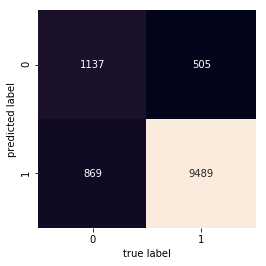

In [19]:
from sklearn.metrics import confusion_matrix
%matplotlib inline  
import seaborn as sns
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Linear SVM - BOW

In [20]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=1, tol=1e-3, C=1, class_weight='balanced').fit(X_train, y_train)

In [21]:
# Predicting the Test set results
y_pred = clf.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\n****Test accuracy %d%%' % (acc))


****Test accuracy 84%


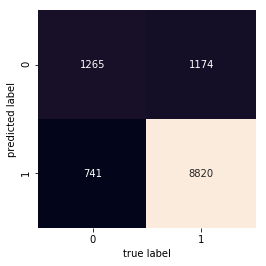

In [23]:
from sklearn.metrics import confusion_matrix
%matplotlib inline  
import seaborn as sns
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# TF_IDF with SVM:

In [31]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.3, random_state=0)

In [32]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english', min_df=20)
final_tf_idf_train = tf_idf_vect.fit_transform(X_train_tfidf)
final_tf_idf_test = tf_idf_vect.transform(X_test_tfidf)

In [33]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(final_tf_idf_train)
# transform both train and test data
final_tf_idf_train = scaler.transform(final_tf_idf_train)
final_tf_idf_test = scaler.transform(final_tf_idf_test)

In [34]:
#C : float, optional (default=1.0) ==> Penalty parameter C of the error term.
#kernel : string, optional (default=’rbf’) ==> Specifies the kernel type to be used in the algorithm. 
#It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used.
#gamma : Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

from sklearn.svm import SVC
clf = SVC(kernel = 'rbf', random_state = 1, C=10, gamma=.0001, class_weight='balanced').fit(final_tf_idf_train, y_train_tfidf)

In [35]:
# Predicting the Test set results
y_pred = clf.predict(final_tf_idf_test)

In [36]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_tfidf, y_pred, normalize=True) * float(100)
print('\n****Test accuracy is %d%%' % (acc))


****Test accuracy is 90%


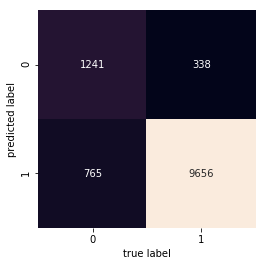

In [37]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
mat = confusion_matrix(y_test_tfidf, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Linear SVM - TFIDF

In [38]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=1, C=10, class_weight='balanced').fit(final_tf_idf_train, y_train_tfidf)

In [39]:
# Predicting the Test set results
y_pred = clf.predict(final_tf_idf_test)

In [40]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_tfidf, y_pred, normalize=True) * float(100)
print('\n****Test accuracy is %d%%' % (acc))


****Test accuracy is 86%


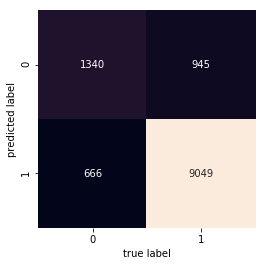

In [41]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
mat = confusion_matrix(y_test_tfidf, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# AvgW2V with SVM

In [42]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_avgw2v, X_test_avgw2v, y_train_avgw2v, y_test_avgw2v = train_test_split(X, y, test_size=0.3, random_state=0)

In [43]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X_train_avgw2v.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [45]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=2,size=50, workers=4)

In [46]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


28000
50


In [47]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent_test=[]
for sent in X_test_avgw2v.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [48]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

12000
50


In [49]:
df_train = pd.DataFrame(sent_vectors)
df_train = df_train.fillna(df_train.mean())
df_test = pd.DataFrame(sent_vectors_test)
df_test = df_test.fillna(df_test.mean())
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train)
# transform both train and test data
standardized_data_train_avgw2v = scaler.transform(df_train)
standardized_data_test_avgw2v = scaler.transform(df_test)

In [50]:
clf = SVC(C = 200, kernel='rbf', gamma=.0001, shrinking=True, random_state=1).fit(standardized_data_train_avgw2v, y_train_avgw2v)

In [51]:
# Predicting the Test set results
y_pred = clf.predict(standardized_data_test_avgw2v)

In [52]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_avgw2v, y_pred, normalize=True) * float(100)
print('\n****Test accuracy is %d%%' % (acc))


****Test accuracy is 87%


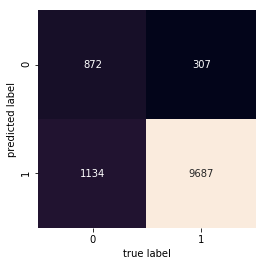

In [53]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
mat = confusion_matrix(y_test_avgw2v, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Linear SVM - AVGW2V

In [54]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=1, C=200, class_weight='balanced').fit(standardized_data_train_avgw2v, y_train_avgw2v)

In [55]:
# Predicting the Test set results
y_pred = clf.predict(standardized_data_test_avgw2v)

In [56]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_avgw2v, y_pred, normalize=True) * float(100)
print('\n****Test accuracy is %d%%' % (acc))


****Test accuracy is 71%


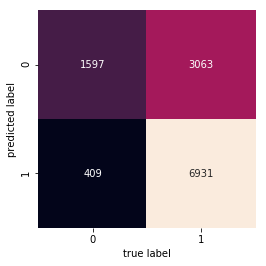

In [57]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
mat = confusion_matrix(y_test_avgw2v, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# TF-IDF- W2V

In [58]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_avgw2vtfidf, X_test_avgw2vtfidf, y_train_avgw2vtfidf, y_test_avgw2vtfidf = train_test_split(X, y, test_size=0.3, random_state=0)

In [59]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X_train_avgw2vtfidf.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [60]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=2,size=50, workers=4)

In [61]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent_test=[]
for sent in X_test_avgw2vtfidf.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [62]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english', min_df=20)
final_tf_idf_train = tf_idf_vect.fit_transform(X_train_avgw2vtfidf)
final_tf_idf_test = tf_idf_vect.transform(X_test_avgw2vtfidf)

##### calculate TF-IDF weighted Word2Vec for train data

In [63]:
# TF-IDF weighted Word2Vec
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
w2v_words = list(w2v_model.wv.vocab)
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

##### calculate TF-IDF weighted Word2Vec for test data

In [64]:
# TF-IDF weighted Word2Vec
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
w2v_words = list(w2v_model.wv.vocab)
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

##### Do standadization for train and test vectors

In [65]:
df_train = pd.DataFrame(tfidf_sent_vectors)
df_train = df_train.fillna(df_train.mean())
df_test = pd.DataFrame(tfidf_sent_vectors_test)
df_test = df_test.fillna(df_test.mean())

from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train)
# transform both train and test data
standardized_data_tf_idfw2v_train = scaler.transform(df_train)
standardized_data_tf_idfw2v_test = scaler.transform(df_test)

In [66]:
clf = SVC(C = 200, kernel='rbf', gamma=.001, shrinking=True, random_state=1).fit(standardized_data_tf_idfw2v_train, y_train_avgw2vtfidf)

In [67]:
# Predicting the Test set results
y_pred = clf.predict(standardized_data_tf_idfw2v_test)

In [68]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_tfidf, y_pred, normalize=True) * float(100)
print('\n****Test accuracy is %d%%' % (acc))


****Test accuracy is 87%


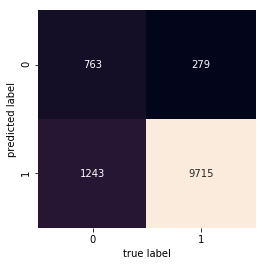

In [69]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
mat = confusion_matrix(y_test_tfidf, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Linear SVM TFIDF-AVGW2V

In [70]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=1, C=200, class_weight='balanced').fit(standardized_data_tf_idfw2v_train, y_train_avgw2vtfidf)

In [71]:
# Predicting the Test set results
y_pred = clf.predict(standardized_data_tf_idfw2v_test)

In [72]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_tfidf, y_pred, normalize=True) * float(100)
print('\n****Test accuracy is %d%%' % (acc))


****Test accuracy is 84%


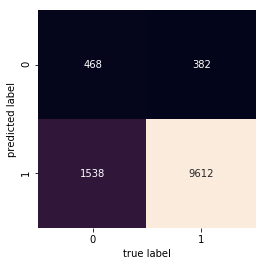

In [73]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
mat = confusion_matrix(y_test_tfidf, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Conclusion:

In [1]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "hyper parameter- C", "hyper parameter- gumma", "test error", "test error Linear SVM"]
x.add_row(["SVM-BOW", 1, .0001, "17%", "16%"])
x.add_row(["SVM-TFIDF", 1, .0001, "17%", "14%"])
x.add_row(["SVM-AVGW2V", 1, .0001, "17%", "29%"])
x.add_row(["SVM-TFIDFAVGW2V", 1, .0001, "17%", "16%"])
print("Featurization With SVM:")
print(x)

Featurization With SVM:
+-----------------+--------------------+------------------------+------------+-----------------------+
|      Model      | hyper parameter- C | hyper parameter- gumma | test error | test error Linear SVM |
+-----------------+--------------------+------------------------+------------+-----------------------+
|     SVM-BOW     |         1          |         0.0001         |    17%     |          16%          |
|    SVM-TFIDF    |         1          |         0.0001         |    17%     |          14%          |
|    SVM-AVGW2V   |         1          |         0.0001         |    17%     |          29%          |
| SVM-TFIDFAVGW2V |         1          |         0.0001         |    17%     |          16%          |
+-----------------+--------------------+------------------------+------------+-----------------------+
